<a href="https://colab.research.google.com/github/JaquesZanon/JOB/blob/main/segmenta%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Martins Segmentação de Representantes
![An image](https://www2.flixdovarejo.com.br/logo/martins/)


In [101]:
!pip install kneed
!pip install feature_engine
!pip install factor_analyzer
!pip install sklearn-som

In [102]:
import os
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from kneed import KneeLocator
#from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
#from yellowbrick.cluster import KElbowVisualizer
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
#from sklearn.cluster import DBSCAN
#from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
#from scipy.cluster import hierarchy
from sklearn.decomposition import FactorAnalysis
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer import (ConfirmatoryFactorAnalyzer,
                              ModelSpecificationParser)
from sklearn_som.som import SOM
from io import StringIO

In [103]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [107]:
#df = pd.read_csv(StringIO(mystr), header=None, sep='|')
df = pd.read_csv('/content/drive/MyDrive/JOB-Martins/segmento.txt', sep='|')

In [108]:
df.head()

,DtMovimento,NrPedido,IdClienteVenda,IdProduto,QtdeVendida,VlVendaLiquido,VlVendaBruto,VlTotalBruto,VlTotalLiquido,VlImpostos,CdCategoria,DsCategoria,CdSubCategoria,DsSubCategoria,IdRepComercial,DtCadastro,DsTipoPessoaRepresentante,DsTipoRepresentante,DsTerritorioVendas,DtCadastroRCA,DtSubstituicaoRepresentante,Vocaçao_dos_Municipios
0,2021-05-24,2974700.0,4391039.0,193931.0,1.0,74.10,78.41,78.41,74.10,13.96,71.0,SABAO/DETERGENTE PARA ROUPA,1.0,DETERGENTE EM PO,1171850.0,2016-12-08,PESSOA FÍSICA,VAREJO ALIMENTAR,BA_ITAPETINGA3_VAR_ATC,2016-12-08,2017-05-11,Núcleos Regionais
1,2021-05-24,2974700.0,4391039.0,216241.0,1.0,116.29,128.50,128.50,116.29,21.92,71.0,SABAO/DETERGENTE PARA ROUPA,1.0,DETERGENTE EM PO,1171850.0,2016-12-08,PESSOA FÍSICA,VAREJO ALIMENTAR,BA_ITAPETINGA3_VAR_ATC,2016-12-08,2017-05-11,Núcleos Regionais
2,2021-05-24,2993905.0,4542353.0,194950.0,3.0,25.99,26.93,80.79,77.97,19.92,14.0,SANDALIA,22.0,CASUAL,1241883.0,2020-02-18,PESSOA FÍSICA,VAREJO ALIMENTAR,BA_SALVADOR60_FAR_CAT,2020-02-18,2020-02-18,Metrópoles Desenvolvidas
3,2021-05-25,3002010.0,428799.0,215740.0,3.0,25.03,27.36,82.08,75.09,19.20,14.0,SANDALIA,22.0,CASUAL,1075456.0,2007-06-20,PESSOA FÍSICA,VAREJO ALIMENTAR,BA_SALVADOR19_VAR_ATC,2007-06-20,2010-07-16,Metrópoles Desenvolvidas
4,2021-05-26,3040084.0,6125928.0,209706.0,2.0,100.10,107.63,215.26,200.20,51.21,15.0,UTILIDADES DOMESTICAS,2.0,ESCADA DOMESTICA,1234508.0,2019-11-22,PESSOA FÍSICA,MARTCON,CE_FORTALEZA31_MAT_CAT,2019-11-22,2019-11-22,Metrópoles Desenvolvidas


In [4]:
#df = pd.read_csv("/content/drive/MyDrive/JOB-Martins/segmentacao.csv",parse_dates=True)
#df = df[df['DtCadastroRCA'].notna()]
#df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (52,55) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [109]:
df.DsTerritorioVendas

0          BA_ITAPETINGA3_VAR_ATC        
1          BA_ITAPETINGA3_VAR_ATC        
2          BA_SALVADOR60_FAR_CAT         
3          BA_SALVADOR19_VAR_ATC         
4          CE_FORTALEZA31_MAT_CAT        
                        ...              
6615546    TO_FORMOSO ARAGUAI1_VAR_ATC   
6615547    MG_SACRAMENTO1_VAR_ATC        
6615548    PR_MARINGA1_VAR_ATC           
6615549    MG_S.JOAO NEPOMUC.1_ELE_CAT   
6615550                               NaN
Name: DsTerritorioVendas, Length: 6615551, dtype: object

### Para gerar a codificação de estados.



In [7]:
mapping = {'DF': 1, 
           'GO': 1,
           'MS': 1,
           'MT': 1, 
           'AC': 2,
           'AM': 2,
           'AP': 2, 
           'PA': 2,
           'RO': 2,
           'RR': 2, 
           'TO': 2,
           'MA': 3,
           'PI': 3, 
           'CE': 3,
           'RN': 3,
           'PB': 3, 
           'PE': 3,
           'AL': 3,
           'SE': 4, 
           'BA': 4,
           'PR': 5,
           'SC': 5, 
           'RS': 5,
           'ES': 6,
           'RJ': 6,
           'MG': 7,
           'SP': 8}

In [8]:
df = df.replace({'CdEstadoTerritorioVendas': mapping}).copy()
df['CdEstadoTerritorioVendas'] = df['CdEstadoTerritorioVendas'].astype('category')
df.CdEstadoTerritorioVendas.unique()

[5, 7, 8, 1, 6, 3, 4, 2]
Categories (8, int64): [5, 7, 8, 1, 6, 3, 4, 2]

# Calculando variaveis auxiliares

In [9]:
# Tempo_Expo
df.DtCadastroRCA = pd.to_datetime(df.DtCadastroRCA).copy()
df.DtMovimento = pd.to_datetime(df.DtMovimento).copy()
df.DtMovimento

### Calculando tempo de explosição

In [11]:
df['Tempo_Expo'] = pd.to_numeric(df.DtMovimento  - df.DtCadastroRCA).copy()
#df.assign(Tempo_expo = pd.to_numeric(df.DtMovimento  - df.DtCadastroRCA)).copy()

In [12]:
#Total_VLRecLiq_Reg 
Total_VLRecLiq_Reg = df.groupby(['CdEstadoTerritorioVendas'])[['VlReceitaLiquida']].agg('sum')

In [13]:
mapping = {'VAREJO ALIMENTAR                        ': 4, 
           'MARTCON                                 ': 3,
           'FARMA NACIONAL                          ': 2,
           'INFORMATICA                             ': 1, 
           'ELETRO                                  ': 1,
           'VETERINARIO                             ': 3
           }

In [14]:
df = df.replace({'DsTipoNegocioRepresentanteComercial': mapping})

In [15]:
#Total_VLRecLiq_TipoRepr 
Total_VLRecLiq_TipoRepr = df.groupby(['DsTipoNegocioRepresentanteComercial'])[['VlReceitaLiquida']].agg('sum')

In [16]:
#Média_QteClientes_TipoRepr
Media_QteClientes_TipoRepr = df.groupby(['DsTipoNegocioRepresentanteComercial'])[['IdClienteEntrega']].nunique()
#df.groupby(['DsTipoNegocioRepresentanteComercial'])[['IdClienteEntrega']].count()
#df.groupby(['DsTipoNegocioRepresentanteComercial'])[['IdRepComercial']].count()
Media_QteClientes_TipoRepr



,IdClienteEntrega
DsTipoNegocioRepresentanteComercial,
1,8
2,17
3,56
4,947


In [17]:
#Média_QteProduto_TipoRepr
Media_QteProduto_TipoRepr = df.groupby(['DsTipoNegocioRepresentanteComercial','NrPedido'])[['QtdeVendida']].mean().groupby(['DsTipoNegocioRepresentanteComercial'])[['QtdeVendida']].mean()
Media_QteProduto_TipoRepr

,QtdeVendida
DsTipoNegocioRepresentanteComercial,
1,3.750000
2,4.250000
3,4.551724
4,7.231520


In [18]:
#Média_QteCategoria_TipoRepr
Media_QteCategoria_TipoRepr = df.groupby(['DsTipoNegocioRepresentanteComercial'])[['CdCategoria']].nunique()
Media_QteCategoria_TipoRepr

,CdCategoria
DsTipoNegocioRepresentanteComercial,
1,7
2,13
3,25
4,63


In [19]:
#Media_QtePedidos_TipoRepr
Media_QtePedidos_TipoRepr = df.groupby(['DsTipoNegocioRepresentanteComercial','Tempo_Expo'])[['NrPedido']].nunique().groupby(['DsTipoNegocioRepresentanteComercial'])[['NrPedido']].mean()
Media_QtePedidos_TipoRepr

,NrPedido
DsTipoNegocioRepresentanteComercial,
1,1.000000
2,1.000000
3,1.074074
4,1.480183


In [ ]:
#df.DsCategoria.unique()

### Variaveis segmentadoras


In [20]:
#V1 Valor da Receita Líquida do Vendedor pelo período de exposição:
V1 = df.groupby(['IdRepComercial'])[['VlReceitaLiquida']].sum().loc[:,'VlReceitaLiquida']/df.groupby(['IdRepComercial'])[['Tempo_Expo']].mean().loc[:,'Tempo_Expo']
V1 = pd.DataFrame(V1).reset_index()
V1

,IdRepComercial,0
0,1052190,9.832645e-17
1,1053746,2.271571e-17
2,1064554,5.970752e-17
3,1065840,5.286133e-15
4,1070515,3.450342e-17
...,...,...
596,1277626,5.017122e-16
597,1277688,4.887742e-16
598,1277776,3.683208e-16
599,1278807,1.437019e-15


In [ ]:
#df[(df.CdEstadoTerritorioVendas == 2) & (df.CdEstadoTerritorioVendas == 1)]
#df["A"][(df["B"] > 50) & (df["C"] == 900)]

In [21]:
#V2 = Importância da receita líquida do Vendedor na região que ele pertence:
rec_reg=df.groupby(['CdEstadoTerritorioVendas'])[['VlReceitaLiquida']].sum().loc[:,'VlReceitaLiquida']
df[df.CdEstadoTerritorioVendas == 1].groupby(['IdRepComercial'])[['VlReceitaLiquida']].sum().loc[:,"VlReceitaLiquida"]/rec_reg.iloc[0]


IdRepComercial
1163525    0.000010
1163842    0.000580
1163933    0.000010
1163985    0.000047
1164159    0.000024
             ...   
1271729    0.000096
1272434    0.000015
1275230    0.000078
1276693    0.000011
1278808    0.000184
Name: VlReceitaLiquida, Length: 69, dtype: float64

In [ ]:
#reduce(sum(), valores)

In [ ]:
# Podemos ver aqui representanrr4es com duas regiões
#df_aux_V2 = df[['IdRepComercial','CdEstadoTerritorioVendas','VlReceitaLiquida']].groupby(['IdRepComercial','CdEstadoTerritorioVendas'])[['VlReceitaLiquida']].sum().dropna().reset_index().copy()

#df_aux_V2=pd.DataFrame(df_aux_V2)

#df_a = df_aux_V2.groupby(['IdRepComercial'])[['CdEstadoTerritorioVendas']].count()
#df_a[df_a.CdEstadoTerritorioVendas==3]

In [ ]:
#df[df.IdRepComercial==1269432]

In [22]:
#V3 Importância da receita líquida do Vendedor categoria Tipo de Representante (Negócio)
rec_area_negocio=df.groupby(['DsTipoNegocioRepresentanteComercial'])[['VlReceitaLiquida']].sum().loc[:,'VlReceitaLiquida']
V3 = pd.DataFrame(df[df.DsTipoNegocioRepresentanteComercial == 1].groupby(['IdRepComercial'])[['VlReceitaLiquida']].sum().loc[:,"VlReceitaLiquida"]/rec_area_negocio.iloc[0]).append([
pd.DataFrame(df[df.DsTipoNegocioRepresentanteComercial == 2].groupby(['IdRepComercial'])[['VlReceitaLiquida']].sum().loc[:,"VlReceitaLiquida"]/rec_area_negocio.iloc[1]),
pd.DataFrame(df[df.DsTipoNegocioRepresentanteComercial == 3].groupby(['IdRepComercial'])[['VlReceitaLiquida']].sum().loc[:,"VlReceitaLiquida"]/rec_area_negocio.iloc[2]),
pd.DataFrame(df[df.DsTipoNegocioRepresentanteComercial == 4].groupby(['IdRepComercial'])[['VlReceitaLiquida']].sum().loc[:,"VlReceitaLiquida"]/rec_area_negocio.iloc[3])]).reset_index()
V3 = V3*100
V3

,IdRepComercial,VlReceitaLiquida
0,108557200,6.894673
1,117182000,7.728125
2,121609400,1.076492
3,121976800,64.699543
4,121996600,17.969154
...,...,...
596,127762600,0.000451
597,127768800,0.000311
598,127777600,0.000119
599,127880700,0.000163


In [ ]:
#rec_area_negocio

In [23]:
#V5 Quantidade de clientes atendidos pelo vendedor em relação a sua categoria Tipo de Representante 
#Média_QteClientes_TipoRepr
#rec_area_negocio=df.groupby(['DsTipoNegocioRepresentanteComercial'])[['VlReceitaLiquida']].sum().loc[:,'VlReceitaLiquida']
V5 = pd.DataFrame(df[df.DsTipoNegocioRepresentanteComercial == 1].groupby(['IdRepComercial'])[['IdClienteEntrega']].nunique().loc[:,"IdClienteEntrega"]/Media_QteClientes_TipoRepr.iloc[0,0]).append([
pd.DataFrame(df[df.DsTipoNegocioRepresentanteComercial == 2].groupby(['IdRepComercial'])[['IdClienteEntrega']].nunique().loc[:,"IdClienteEntrega"]/Media_QteClientes_TipoRepr.iloc[1,0]),
pd.DataFrame(df[df.DsTipoNegocioRepresentanteComercial == 3].groupby(['IdRepComercial'])[['IdClienteEntrega']].nunique().loc[:,"IdClienteEntrega"]/Media_QteClientes_TipoRepr.iloc[2,0]),
pd.DataFrame(df[df.DsTipoNegocioRepresentanteComercial == 4].groupby(['IdRepComercial'])[['IdClienteEntrega']].nunique().loc[:,"IdClienteEntrega"]/Media_QteClientes_TipoRepr.iloc[3,0])]).reset_index()
V5

,IdRepComercial,IdClienteEntrega
0,1085572,0.125000
1,1171820,0.125000
2,1216094,0.125000
3,1219768,0.125000
4,1219966,0.125000
...,...,...
596,1277626,0.002112
597,1277688,0.001056
598,1277776,0.001056
599,1278807,0.001056


In [24]:
# V6 Quantidade de itens por quantidade em relação ao Tipo de Representante
V6 = pd.DataFrame(df[df.DsTipoNegocioRepresentanteComercial == 1].groupby(['IdRepComercial'])[['QtdeVendida']].sum().loc[:,"QtdeVendida"]/Media_QteProduto_TipoRepr.iloc[0,0]).append([
pd.DataFrame(df[df.DsTipoNegocioRepresentanteComercial == 2].groupby(['IdRepComercial'])[['QtdeVendida']].sum().loc[:,"QtdeVendida"]/Media_QteProduto_TipoRepr.iloc[1,0]),
pd.DataFrame(df[df.DsTipoNegocioRepresentanteComercial == 3].groupby(['IdRepComercial'])[['QtdeVendida']].sum().loc[:,"QtdeVendida"]/Media_QteProduto_TipoRepr.iloc[2,0]),
pd.DataFrame(df[df.DsTipoNegocioRepresentanteComercial == 4].groupby(['IdRepComercial'])[['QtdeVendida']].sum().loc[:,"QtdeVendida"]/Media_QteProduto_TipoRepr.iloc[3,0])]).reset_index()
V6 

,IdRepComercial,QtdeVendida
0,1085572,0.266667
1,1171820,2.133333
2,1216094,3.200000
3,1219768,1.066667
4,1219966,2.133333
...,...,...
596,1277626,0.829701
597,1277688,0.138284
598,1277776,0.276567
599,1278807,1.659402


In [25]:
#V7 
V7 = pd.DataFrame(df[df.DsTipoNegocioRepresentanteComercial == 1].groupby(['IdRepComercial'])[['DsCategoria']].nunique().loc[:,"DsCategoria"]/Media_QteCategoria_TipoRepr.iloc[0,0]).append([
pd.DataFrame(df[df.DsTipoNegocioRepresentanteComercial == 2].groupby(['IdRepComercial'])[['DsCategoria']].nunique().loc[:,"DsCategoria"]/Media_QteCategoria_TipoRepr.iloc[1,0]),
pd.DataFrame(df[df.DsTipoNegocioRepresentanteComercial == 3].groupby(['IdRepComercial'])[['DsCategoria']].nunique().loc[:,"DsCategoria"]/Media_QteCategoria_TipoRepr.iloc[2,0]),
pd.DataFrame(df[df.DsTipoNegocioRepresentanteComercial == 4].groupby(['IdRepComercial'])[['DsCategoria']].nunique().loc[:,"DsCategoria"]/Media_QteCategoria_TipoRepr.iloc[3,0])]).reset_index()
V7 


,IdRepComercial,DsCategoria
0,1085572,0.142857
1,1171820,0.142857
2,1216094,0.142857
3,1219768,0.142857
4,1219966,0.142857
...,...,...
596,1277626,0.015873
597,1277688,0.015873
598,1277776,0.015873
599,1278807,0.015873


In [ ]:
#% load_ext rpy2.ipython

In [ ]:
#%%R
#x <- 42
#print(x)

In [26]:
#V8 
V8 = pd.DataFrame((df[df.DsTipoNegocioRepresentanteComercial == 1].groupby(['IdRepComercial'])[['NrPedido']].nunique().reset_index().loc[:,"NrPedido"]/df[df.DsTipoNegocioRepresentanteComercial == 1].groupby(['IdRepComercial'])[['Tempo_Expo']].mean().reset_index().loc[:,"Tempo_Expo"])/Media_QtePedidos_TipoRepr.iloc[0,0]).append([
pd.DataFrame((df[df.DsTipoNegocioRepresentanteComercial == 2].groupby(['IdRepComercial'])[['NrPedido']].nunique().reset_index().loc[:,"NrPedido"]/df[df.DsTipoNegocioRepresentanteComercial == 2].groupby(['IdRepComercial'])[['Tempo_Expo']].mean().reset_index().loc[:,"Tempo_Expo"])/Media_QtePedidos_TipoRepr.iloc[1,0]),
pd.DataFrame((df[df.DsTipoNegocioRepresentanteComercial == 3].groupby(['IdRepComercial'])[['NrPedido']].nunique().reset_index().loc[:,"NrPedido"]/df[df.DsTipoNegocioRepresentanteComercial == 3].groupby(['IdRepComercial'])[['Tempo_Expo']].mean().reset_index().loc[:,"Tempo_Expo"])/Media_QtePedidos_TipoRepr.iloc[2,0]),
pd.DataFrame((df[df.DsTipoNegocioRepresentanteComercial == 4].groupby(['IdRepComercial'])[['NrPedido']].nunique().reset_index().loc[:,"NrPedido"]/df[df.DsTipoNegocioRepresentanteComercial == 4].groupby(['IdRepComercial'])[['Tempo_Expo']].mean().reset_index().loc[:,"Tempo_Expo"])/Media_QtePedidos_TipoRepr.iloc[3,0])])
V8 = V8.reset_index()
V8.columns = ['index', "V8"]
V8

,index,V8
0,0,3.070861e-18
1,1,6.380416e-18
2,2,2.726519e-18
3,3,1.454943e-18
4,4,1.509990e-18
...,...,...
596,525,9.786425e-18
597,526,6.919782e-18
598,527,1.357527e-17
599,528,3.870967e-17


In [ ]:
V8

,index,V8
0,0,3.070861e-18
1,1,6.380416e-18
2,2,2.726519e-18
3,3,1.454943e-18
4,4,1.509990e-18
...,...,...
596,525,9.786425e-18
597,526,6.919782e-18
598,527,1.357527e-17
599,528,3.870967e-17


In [27]:
var_seg = pd.concat([V1, V3.loc[:,'VlReceitaLiquida'],V5.loc[:,'IdClienteEntrega'],V6.loc[:,'QtdeVendida'],V7.loc[:,'DsCategoria'],V8.loc[:,"V8"]], axis=1)
var_seg.columns = ['rep_comercial','V1','V3','V5',"V6","V7","V8"]
var_seg.index = var_seg['rep_comercial']
var_seg = var_seg.drop("rep_comercial", axis=1)

In [28]:
var_seg.describe().round(5)

,V1,V3,V5,V6,V7,V8
count,601.0,601.00000,601.00000,601.00000,601.00000,601.0
mean,0.0,0.66556,0.00666,20.93845,0.02895,0.0
std,0.0,5.21193,0.02130,352.07783,0.04095,0.0
min,-0.0,-0.14216,0.00106,0.13828,0.01587,0.0
25%,0.0,0.00025,0.00106,0.27657,0.01587,0.0
50%,0.0,0.00062,0.00106,0.69142,0.01587,0.0
75%,0.0,0.00217,0.00211,1.79769,0.03175,0.0
max,0.0,97.91266,0.25238,8458.66425,0.85714,0.0


In [29]:
num_vars = ['V1',
       'V3', 'V5', 'V6',
       'V7', 'V8']
std_scaler = SklearnTransformerWrapper(transformer=StandardScaler(),
                                      variables = num_vars)

In [ ]:
#std_scaler = SklearnTransformerWrapper(transformer=MinMaxScaler(),
#                                     variables = num_vars)

#### Padronizando Variáveis

In [30]:
df_aux_sc = std_scaler.fit_transform(var_seg)

In [31]:
df_aux_sc.columns

Index(['V1', 'V3', 'V5', 'V6', 'V7', 'V8'], dtype='object')

### Testes para verificar a analise fatorial

Bartlett’s test of sphericity checks whether or not the observed variables intercorrelate at all using the observed correlation matrix against the identity matrix. If the test found statistically insignificant, you should not employ a factor analysis.

In [32]:
chi_square_value,p_value=calculate_bartlett_sphericity(df_aux_sc)
chi_square_value, p_value

(2443.630632454803, 0.0)

Kaiser-Meyer-Olkin (KMO) Test measures the suitability of data for factor analysis. It determines the adequacy for each observed variable and for the complete model. KMO estimates the proportion of variance among all the observed variable. Lower proportion id more suitable for factor analysis. KMO values range between 0 and 1. Value of KMO less than 0.6 is considered inadequate.

In [33]:
kmo_all,kmo_model=calculate_kmo(df_aux_sc)
kmo_model

0.7211782256143906

In [67]:
#EXPLORATORY FACTOR ANALYSIS
fa = FactorAnalyzer(3, rotation=None)
fa.fit(df_aux_sc)

#FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
#               method='minres', n_factors=3, rotation=None, rotation_kwargs={},
#               use_smc=True)



FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='minres', n_factors=3, rotation=None, rotation_kwargs={},
               use_smc=True)

In [68]:
#Variacia explicada dos dados
pd.DataFrame(fa.get_factor_variance())

,0,1,2
0,3.398941,0.470949,0.227120
1,0.566490,0.078492,0.037853
2,0.566490,0.644982,0.682835


In [64]:
#GET EIGENVALUES
ev, v = fa.get_eigenvalues()

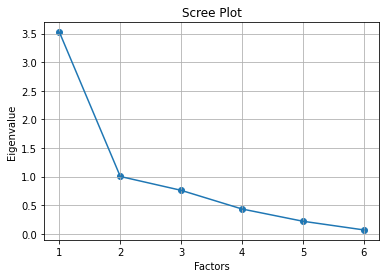

In [36]:
# SCREEPLOT (need pyplot)
plt.scatter(range(1,df_aux_sc.shape[1]+1),ev)
plt.plot(range(1,df_aux_sc.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [70]:
fa = FactorAnalyzer(3, rotation="Varimax")
fa.fit(df_aux_sc)
fa.get_factor_variance()
fa.loadings_

array([[ 0.00164523, -0.01879332, -0.00149328],
       [ 0.5699135 ,  0.30792065,  0.75433596],
       [ 0.42212132,  0.7709033 ,  0.24633408],
       [ 0.88649485,  0.00806652,  0.31627703],
       [ 0.82217539,  0.51208784,  0.23925216],
       [ 0.61192978,  0.03238873,  0.13390278]])

In [71]:
fa.get_factor_variance()

(array([2.33929407, 0.95280827, 0.80490816]),
 array([0.38988235, 0.15880138, 0.13415136]),
 array([0.38988235, 0.54868372, 0.68283508]))

In [72]:
loadings = pd.DataFrame(fa.loadings_, columns=['Factor 1', 'Factor 2', 'Factor 3', 'Factor 4','Factor 5','Factor 6'], index=df_aux_sc.columns)
print('Factor Loadings \n%s' %loadings)

ValueError: ignored

### Análise Fatorial Confirmatória

In [73]:
model_dict = {"F1": ["V1", "V3"],
              "F2": [ "V6", "V7", "V8"],
              "F3": ['V5']}
model_spec = ModelSpecificationParser.parse_model_specification_from_dict(df_aux_sc, model_dict)
cfa = ConfirmatoryFactorAnalyzer(model_spec, disp=False)
cfa.fit(df_aux_sc)
cfa.loadings_.round(2)

array([[-0.8 ,  0.  ,  0.  ],
       [-0.56,  0.  ,  0.  ],
       [ 0.  , -0.03,  0.  ],
       [ 0.  ,  0.01,  0.  ],
       [ 0.  ,  1.09,  0.  ],
       [ 0.  ,  0.  , -0.36]])

In [100]:
# Calculo dos autovalores
sum(pd.DataFrame(cfa.loadings_.round(2)).iloc[:,0]**2)+sum(pd.DataFrame(cfa.loadings_.round(2)).iloc[:,1]**2)+sum(pd.DataFrame(cfa.loadings_.round(2)).iloc[:,2]**2)

2.2723000000000004

In [53]:
fact_trans = pd.DataFrame(cfa.fit_transform(df_aux_sc))
um = (fact_trans.iloc[:,0]-min(fact_trans.iloc[:,0]))/(max(fact_trans.iloc[:,0])-min(fact_trans.iloc[:,0]))
dois = (fact_trans.iloc[:,1]-min(fact_trans.iloc[:,1]))/(max(fact_trans.iloc[:,1])-min(fact_trans.iloc[:,1]))
tres = (fact_trans.iloc[:,2]-min(fact_trans.iloc[:,2]))/(max(fact_trans.iloc[:,2])-min(fact_trans.iloc[:,2]))

In [54]:
Indicador_Norm = pd.DataFrame(pd.concat([um,dois,tres],axis=1))

In [55]:
Indicador_Norm = np.where(Indicador_Norm < 0, 0, Indicador_Norm)
Indicador_Norm = np.where(Indicador_Norm > 1, 1, Indicador_Norm)
Indicador_Norm 


array([[0.95741471, 0.06524665, 0.99003479],
       [0.95237393, 0.06526987, 0.97654041],
       [0.99262831, 0.06528314, 0.99143881],
       ...,
       [0.99912904, 0.00263485, 0.9472041 ],
       [0.99908194, 0.00265206, 0.84472102],
       [0.99788895, 0.00265206, 0.72040857]])

In [ ]:
Indicador_Final = []

In [ ]:
 #A list holds the SSE values for each k
sse = []
for k in range(1, 21):
        kmeans = KMeans(n_clusters=k,max_iter=300)
        kmeans.fit(df_aux_sc)
        sse.append(kmeans.inertia_)


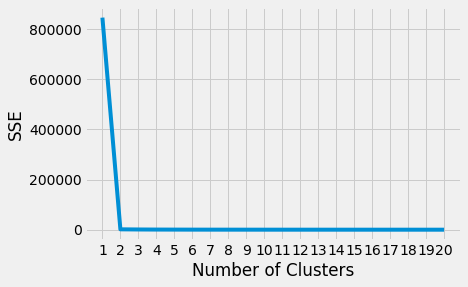

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 21), sse)
plt.xticks(range(1, 21))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

#### Esse resultado abaixo mostra o numero de grupos ótimo igual a 5.

In [ ]:
kl = KneeLocator(
        range(1, 21), sse, curve="convex", direction="decreasing"
    )
kl.elbow

2

In [ ]:
kmeans = KMeans(
   init="random",
   n_clusters=2,
   n_init=10,
   max_iter=400,
   random_state=42
)

In [ ]:
kresultado = kmeans.fit(df_aux_sc)

In [ ]:
df_aux_sc["segKmeans"] = kresultado.labels_

#### Visualizando o resultado K-means

In [ ]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_aux_sc)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df_aux_sc[['segKmeans']]], axis = 1)

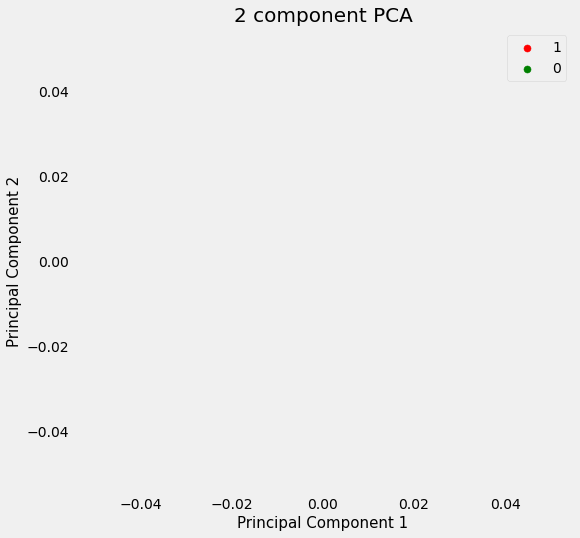

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = df_aux_sc.segKmeans.unique()
colors = ['r', 'g', 'b', 'black', 'cyan']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['segKmeans'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_))#loadings

,0,1
0,0.000375,0.003666
1,0.030070,-0.005476
2,0.030214,-0.005368
3,0.002437,0.006022
4,0.002595,0.006323
5,0.002779,0.006576
6,0.002457,0.005945
7,0.002183,0.004901
8,0.004019,0.010933
9,0.004214,0.006853


In [ ]:
df_aux_sc["SegKmeans"] = df.segKmeans

In [ ]:
tabulacao = df_aux_sc.groupby('SegKmeans').mean()
tabulacao

,QtdeVendida,VlVendaLiquido,VlVendaBruto,VlTotalBruto,VlTotalLiquido,VlImpostos,VlReceitaLiquida,VlLogTranspCubico,VlLogArmazenagem,VlLogCustoDistribuicao,CMV,VlFunding,VlDespVenCustoReprFuncionario,VlDespVenCustoVender,VlDespVenCustoComissao,VlMrgContribuicao,VlDescTotal,VlMrgBruta,VlEncargosVendor,VlGapVendor
SegKmeans,,,,,,,,,,,,,,,,,,,,
0,0.000094,0.084998,0.085947,0.004196,0.004505,0.005017,0.038638,0.003944,0.008943,0.015623,0.003339,0.000659,0.000372,0.003746,0.011825,0.090332,0.012907,0.076038,0.000896,0.000348
1,0.000826,0.005512,0.005711,0.000570,0.000597,0.000692,0.034921,0.000788,0.002099,0.005723,0.000448,0.000183,0.000496,0.000493,0.002400,0.085127,0.002662,0.068149,0.000029,0.000032
2,0.000023,0.325371,0.326086,0.012195,0.013279,0.014555,0.047014,0.012652,0.019749,0.031251,0.010248,0.001796,0.000000,0.000097,0.026095,0.099263,0.023645,0.090145,0.007890,0.003994
3,0.147326,0.029461,0.030977,0.347681,0.369466,0.392389,0.386385,0.261483,0.590537,0.302528,0.344819,0.356177,0.000000,0.010370,0.610123,0.521336,0.083333,0.583537,0.000070,0.099253
4,0.055381,0.026072,0.027710,0.043458,0.045252,0.041002,0.073192,0.048027,0.110280,0.089146,0.033811,0.022393,0.000000,0.009470,0.126962,0.138736,0.159947,0.139937,0.001113,0.005269


Text(0.5, 6.719999999999981, 'Features')

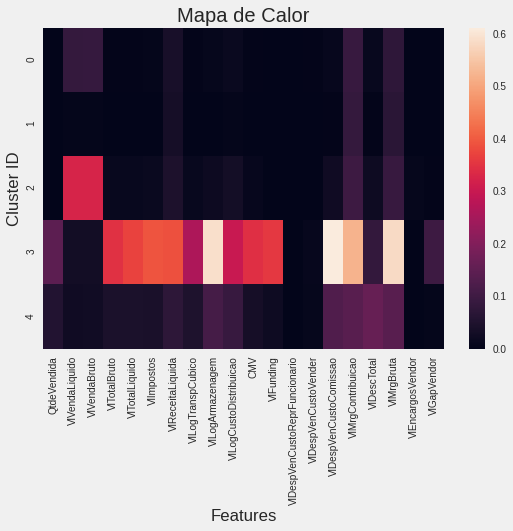

In [ ]:
fig, ax=plt.subplots()
sns.heatmap(tabulacao, ax=ax, annot = False);
ax.set_title("Mapa de Calor");
ax.set_ylabel("Cluster ID");
ax.set_xlabel("Features")

In [ ]:
df_rfv = df.groupby